# Identify Handwritten Symbols with a Convolutional Neural Network 

## Modules

In [1]:
import random
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import precision_score, recall_score, confusion_matrix

## Config

In [2]:
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)

TRAIN_DATA_DIR = "./digits_mirror/train"
TEST_DATA_DIR = "./digits_mirror/test"
PRETRAIN = True
BATCH_SIZE = 32

## Utilities

In [3]:
def plot_learning_curve(history, indicator=None):
    fig, ax = plt.subplots(figsize=(12, 6))

    ax.set_title(f"Learning Curve ({indicator.upper()})")
    ax.plot(history.history[indicator], label="train")
    ax.plot(history.history[f"val_{indicator}"], label="val")

    plt.legend()
    plt.show()

## Read Own-Dataset

In [4]:
SPLIT      = 0.2
IMAGE_SIZE = 28

print("train")
train = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DATA_DIR,
    validation_split=SPLIT,
    seed=42,
    color_mode="grayscale",
    subset="training",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

print("val")
val = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DATA_DIR,
    validation_split=SPLIT,
    seed=42,
    color_mode="grayscale",
    subset="validation",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

print("test")
test = tf.keras.utils.image_dataset_from_directory(
    TEST_DATA_DIR,
    seed=42,
    shuffle=True,
    color_mode="grayscale",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=1000,
)

train
Found 509 files belonging to 10 classes.
Using 408 files for training.
val
Found 509 files belonging to 10 classes.
Using 101 files for validation.
test
Found 109 files belonging to 10 classes.


2022-08-21 10:26:38.182458: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Read MNIST-Dataset

In [5]:
(mnist_train, mnist_val), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
    batch_size=BATCH_SIZE
)

## Create Model

In [6]:
model = tf.keras.Sequential()
dropout = 0.1
channel = 32

model.add(tf.keras.layers.RandomRotation(0.1, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
model.add(tf.keras.layers.RandomZoom(0.1))
model.add(tf.keras.layers.RandomContrast(0.1))
model.add(tf.keras.layers.RandomBrightness(0.1))
model.add(tf.keras.layers.Rescaling(1./255))
model.add(tf.keras.layers.Conv2D(channel, 3, activation="relu"))
model.add(tf.keras.layers.Dropout(dropout))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(channel, 3, activation="relu"))
model.add(tf.keras.layers.Dropout(dropout))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation (RandomRota  (None, 28, 28, 1)        0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 28, 28, 1)         0         
                                                                 
 random_contrast (RandomCont  (None, 28, 28, 1)        0         
 rast)                                                           
                                                                 
 random_brightness (RandomBr  (None, 28, 28, 1)        0         
 ightness)                                                       
                                                                 
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                        

## Train model on MNIST-Dataset

In [7]:
if PRETRAIN:
    history = model.fit(mnist_train, validation_data=mnist_val, epochs=10)

Epoch 1/10


1875/1875 [==============================] - 172s 89ms/step - loss: 0.3113 - accuracy: 0.9031 - val_loss: 0.1001 - val_accuracy: 0.9705
Epoch 2/10
1875/1875 [==============================] - 162s 86ms/step - loss: 0.1329 - accuracy: 0.9598 - val_loss: 0.0752 - val_accuracy: 0.9761
Epoch 3/10
1875/1875 [==============================] - 103s 55ms/step - loss: 0.1052 - accuracy: 0.9677 - val_loss: 0.0620 - val_accuracy: 0.9799
Epoch 4/10
1875/1875 [==============================] - 85s 45ms/step - loss: 0.0910 - accuracy: 0.9722 - val_loss: 0.0574 - val_accuracy: 0.9818
Epoch 5/10
1875/1875 [==============================] - 94s 50ms/step - loss: 0.0821 - accuracy: 0.9750 - val_loss: 0.0447 - val_accuracy: 0.9848
Epoch 6/10
1875/1875 [==============================] - 75s 40ms/step - loss: 0.0754 - accuracy: 0.9770 - val_loss: 0.0482 - val_accuracy: 0.9838
Epoch 7/10
1875/1875 [==============================] - 76s 41ms/step - loss: 0.0701 - accuracy: 0.9782 - val_loss: 0.0435 - val_acc

### Debug training

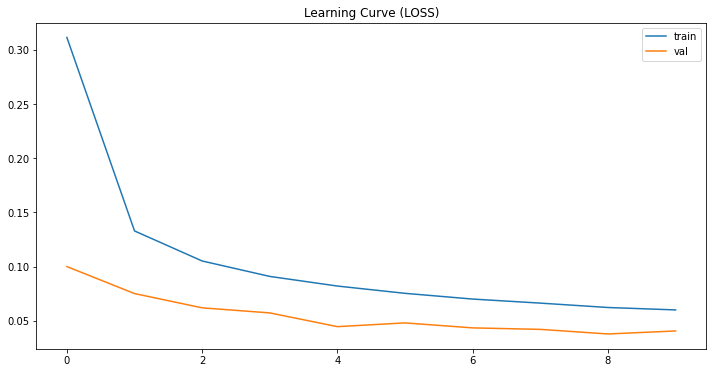

In [8]:
if PRETRAIN:
    plot_learning_curve(history, indicator="loss")

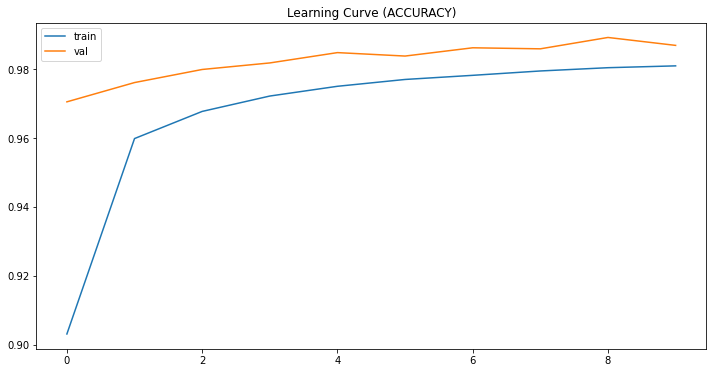

In [9]:
if PRETRAIN:
    plot_learning_curve(history, indicator="accuracy")

## Train model on OWN-Dataset

In [10]:
history = model.fit(train, validation_data=val, epochs=100)

Epoch 1/100


13/13 [==============================] - 8s 129ms/step - loss: 2.7814 - accuracy: 0.1765 - val_loss: 2.1511 - val_accuracy: 0.2970
Epoch 2/100
13/13 [==============================] - 1s 85ms/step - loss: 2.0284 - accuracy: 0.3039 - val_loss: 1.7179 - val_accuracy: 0.3564
Epoch 3/100
13/13 [==============================] - 1s 95ms/step - loss: 1.8598 - accuracy: 0.3578 - val_loss: 1.4445 - val_accuracy: 0.4950
Epoch 4/100
13/13 [==============================] - 1s 95ms/step - loss: 1.6150 - accuracy: 0.4657 - val_loss: 1.2025 - val_accuracy: 0.5644
Epoch 5/100
13/13 [==============================] - 1s 89ms/step - loss: 1.4815 - accuracy: 0.5270 - val_loss: 0.9922 - val_accuracy: 0.6733
Epoch 6/100
13/13 [==============================] - 1s 89ms/step - loss: 1.3335 - accuracy: 0.5711 - val_loss: 0.8573 - val_accuracy: 0.7228
Epoch 7/100
13/13 [==============================] - 1s 89ms/step - loss: 1.1259 - accuracy: 0.6201 - val_loss: 0.7316 - val_accuracy: 0.7921
Epoch 8/100
13/13

### Debug training

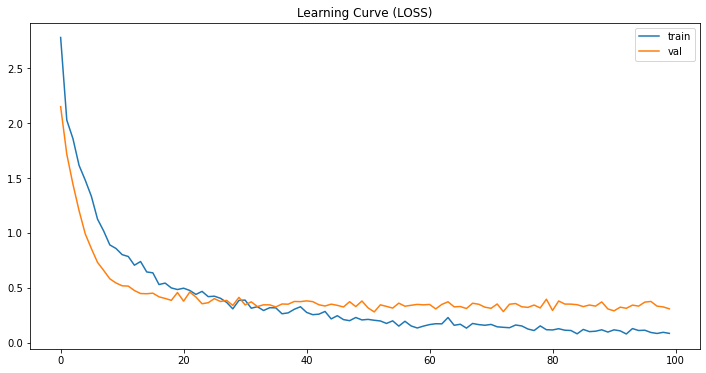

In [11]:
plot_learning_curve(history, indicator="loss")

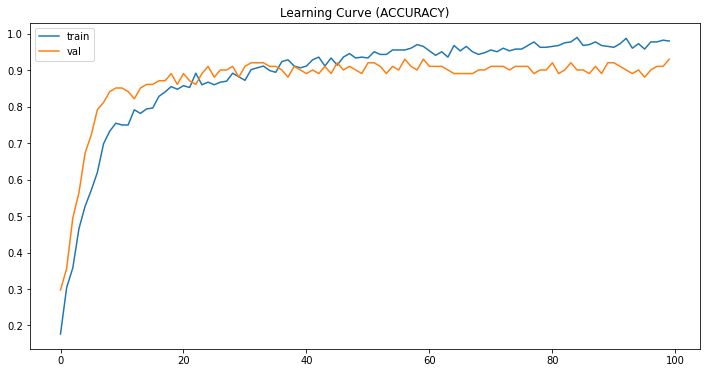

In [12]:
plot_learning_curve(history, indicator="accuracy")

## Evaluate Model

In [13]:
test_data = list(test)
x_test = test_data[0][0].numpy()
y_test = test_data[0][1].numpy()

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred

4/4 [==============================] - 1s 13ms/step


array([2, 3, 3, 1, 7, 1, 0, 1, 3, 5, 4, 2, 4, 3, 9, 0, 4, 6, 7, 6, 6, 6,
       3, 0, 4, 7, 5, 2, 5, 0, 5, 9, 9, 0, 6, 6, 1, 1, 5, 5, 7, 2, 2, 9,
       7, 9, 6, 2, 7, 2, 3, 7, 5, 9, 0, 6, 5, 4, 4, 3, 8, 3, 0, 2, 8, 2,
       1, 0, 6, 1, 3, 1, 1, 0, 0, 9, 3, 5, 8, 0, 0, 7, 2, 7, 4, 8, 7, 8,
       2, 0, 9, 8, 8, 8, 6, 9, 9, 4, 8, 1, 2, 0, 5, 7, 4, 0, 8, 6, 0])

### Precision

In [14]:
y_pred

array([2, 3, 3, 1, 7, 1, 0, 1, 3, 5, 4, 2, 4, 3, 9, 0, 4, 6, 7, 6, 6, 6,
       3, 0, 4, 7, 5, 2, 5, 0, 5, 9, 9, 0, 6, 6, 1, 1, 5, 5, 7, 2, 2, 9,
       7, 9, 6, 2, 7, 2, 3, 7, 5, 9, 0, 6, 5, 4, 4, 3, 8, 3, 0, 2, 8, 2,
       1, 0, 6, 1, 3, 1, 1, 0, 0, 9, 3, 5, 8, 0, 0, 7, 2, 7, 4, 8, 7, 8,
       2, 0, 9, 8, 8, 8, 6, 9, 9, 4, 8, 1, 2, 0, 5, 7, 4, 0, 8, 6, 0])

In [15]:
y_test

array([2, 3, 3, 1, 7, 1, 0, 1, 3, 5, 4, 2, 4, 3, 9, 0, 4, 6, 7, 6, 6, 6,
       3, 0, 4, 7, 5, 2, 5, 0, 5, 9, 9, 0, 6, 6, 1, 1, 5, 5, 7, 2, 2, 9,
       7, 9, 6, 2, 7, 5, 3, 7, 5, 9, 0, 6, 5, 4, 4, 3, 8, 3, 0, 2, 8, 2,
       1, 0, 6, 1, 3, 1, 1, 0, 0, 9, 3, 5, 8, 0, 0, 2, 2, 7, 4, 8, 7, 8,
       5, 0, 9, 8, 8, 8, 6, 9, 9, 4, 8, 1, 2, 0, 5, 7, 4, 0, 8, 4, 0],
      dtype=int32)

In [16]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.963302752293578

In [17]:
precision_score(y_test, y_pred, labels=[i for i in range(10)], average=None)

array([1.        , 1.        , 0.83333333, 1.        , 1.        ,
       1.        , 0.90909091, 0.90909091, 1.        , 1.        ])

### Recall

In [18]:
recall_score(y_test, y_pred, labels=[i for i in range(10)], average=None)

array([1.        , 1.        , 0.90909091, 1.        , 0.9       ,
       0.83333333, 1.        , 1.        , 1.        , 1.        ])

### Confusion Matrix

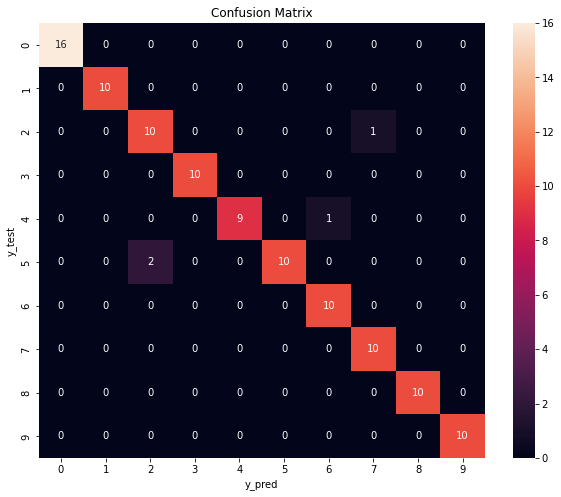

In [19]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10, 8))
s = sns.heatmap(cm, annot=True, ax=ax)
# TODO: check proper ordering y_pred-y_test y_axis-x_axis
s.set(xlabel='y_pred', ylabel='y_test', title="Confusion Matrix")
plt.show()

## Save Model

In [20]:
model.save("model")

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets
